# Product Segmentation using Clustering

In this notebook, we perform unsupervised product segmentation on the **Online Retail** dataset using **KMeans Clustering**.

### Objective
Segment products based on:
- Total quantity sold
- Average price per unit
- Number of transactions sold in

This helps retailers:
- Tailor promotions and bundling
- Prioritize inventory based on sales behavior

## Step 1: Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

## Step 2: Load and Clean the Dataset

In [2]:
df = pd.read_csv('../Data/Online_Retail.csv')
# Drop missing values
df = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
                       'UnitPrice', 'CustomerID', 'Country'])
# Convert invoiceDate to date-time formate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=False)

C:\Users\joemo\AppData\Local\Temp\ipykernel_15488\74501951.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=False)


In [3]:
# Preview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Step 3: Product-Level Feature Engineering

We group the data by product (`StockCode`) to compute:

- Total quantity sold
- Average price per unit
- Number of transactions the product appears in

We'll also create a `TotalRevenue` column for additional insight.


In [4]:
# Creating Product-level feature set
product_df = df.groupby('StockCode').agg({
    'Description': 'first',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': pd.Series.nunique
}).rename(columns={
    'InvoiceNo': 'TransactionCount',
    'Quantity': 'TotalQuantitySold',
    'UnitPrice': 'AvgUnitPrice'
})
# Adding the total revenue column for EDA
product_df['TotalRevenue'] = product_df['TotalQuantitySold'] * product_df['AvgUnitPrice']
# Reset index so StockCode becomes a regular column instead of an index
product_df = product_df.reset_index()

In [5]:
# Preview
product_df.head()

,StockCode,Description,TotalQuantitySold,AvgUnitPrice,TransactionCount,TotalRevenue
0,10002,INFLATABLE POLITICAL GLOBE,823,0.850000,49,699.550000
1,10080,GROOVY CACTUS INFLATABLE,291,0.411905,21,119.864286
2,10120,DOGGY RUBBER,193,0.210000,29,40.530000
3,10123C,HEARTS WRAPPING TAPE,5,0.650000,3,3.250000
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,0.420000,5,6.720000


## Step 4: Feature Selection and Scaling

We’ll select 3 numeric features that capture product-level sales behavior:

- TotalQuantitySold
- AvgUnitPrice
- TransactionCount

Then we’ll scale the data using **StandardScaler** before clustering.


In [7]:
# Feature selection
X = product_df.loc[:, ['TotalQuantitySold', 'AvgUnitPrice', 'TransactionCount']]

# Feature scaling
sc = StandardScaler()
X = sc.fit_transform(X)

## Step 5: KMeans Clustering and Elbow Method

We’ll use the elbow method to determine the optimal number of clusters based on WCSS (Within-Cluster Sum of Squares), and then apply KMeans clustering.

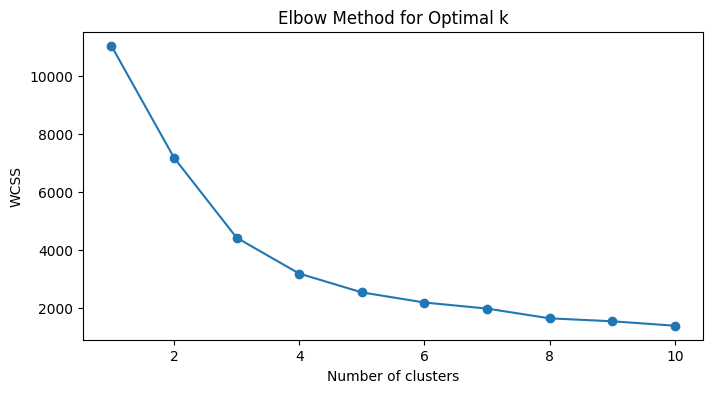

In [9]:
# Elbow method to find optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

## Step 6: Applying KMeans Clustering

We’ll use `k=3` clusters (based on the elbow method) and assign a cluster label to each product.

In [12]:
# Fit KMeans with optimal clusters k=3
km = KMeans(n_clusters=3, init='k-means++', random_state=0)
y_kmeans = km.fit_predict(X)

# Inserting the cluster label to the product data frame
product_df['Cluster(KMeans)'] = y_kmeans

In [13]:
# Preview with clusters
product_df.head()

,StockCode,Description,TotalQuantitySold,AvgUnitPrice,TransactionCount,TotalRevenue,Cluster(KMeans)
0,10002,INFLATABLE POLITICAL GLOBE,823,0.850000,49,699.550000,0
1,10080,GROOVY CACTUS INFLATABLE,291,0.411905,21,119.864286,0
2,10120,DOGGY RUBBER,193,0.210000,29,40.530000,0
3,10123C,HEARTS WRAPPING TAPE,5,0.650000,3,3.250000,0
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,0.420000,5,6.720000,0


## Step 7: KMeans Cluster Summary

Let’s analyze how each cluster differs based on:

- Average quantity sold
- Average price per unit
- Number of transactions the product appears in

In [14]:
# Grouping by the kmeans clusters
km_cluster_summary = product_df.groupby('Cluster(KMeans)')[['TotalQuantitySold', 'AvgUnitPrice', 'TransactionCount']].mean()
print("KMeans Cluster Summary:")
print(km_cluster_summary)

KMeans Cluster Summary:
                 TotalQuantitySold  AvgUnitPrice  TransactionCount
Cluster(KMeans)                                                   
0                       747.402989      3.507642         73.573564
1                      8749.312268      2.244919        539.791822
2                      1061.333333    524.804170        148.000000


## Insights from KMeans Clustering

Based on the clustering results, we observe three distinct product segments:

#### Cluster 0 — Low Revenue, Low Volume Products
- Moderate average quantity sold (~747 units)
- Low average price (~3.5 GBP)
- Low transaction count (~74)
- These products are relatively low in demand and contribute little to overall revenue.
- **Suggested actions**: Evaluate product relevance, consider bundling with popular items, or offer discounts.

#### Cluster 1 — High Volume, Low-Cost Products
- Very high average quantity sold (~8749 units)
- Low average price (~2.2 GBP)
- High transaction count (~540)
- These are fast-moving products with high demand and frequent purchases.
- **Suggested actions**: Ensure consistent stock availability, use them in promotions, and explore cross-selling opportunities.

#### Cluster 2 — High Revenue, Premium Products
- Moderate quantity sold (~1061 units)
- Very high average price (~524 GBP)
- Moderate transaction count (~148)
- These are high-value items that generate significant revenue despite lower purchase frequency.
- **Suggested actions**: Use targeted marketing, explore loyalty incentives, and bundle with complementary items.


## Step 8: Labeling the Clusters

To improve readability and interpretability, we replace the numeric cluster values with meaningful labels based on sales behavior.

In [18]:
product_df['Cluster(KMeans)'] = product_df['Cluster(KMeans)'].replace({
    0: 'Low Volume - Low Price',
    1: 'High Volume - Low Price',
    2: 'Moderate Volume - High Price'
})

In [19]:
product_df.head()

,StockCode,Description,TotalQuantitySold,AvgUnitPrice,TransactionCount,TotalRevenue,Cluster(KMeans)
0,10002,INFLATABLE POLITICAL GLOBE,823,0.850000,49,699.550000,Low Volume - Low Price
1,10080,GROOVY CACTUS INFLATABLE,291,0.411905,21,119.864286,Low Volume - Low Price
2,10120,DOGGY RUBBER,193,0.210000,29,40.530000,Low Volume - Low Price
3,10123C,HEARTS WRAPPING TAPE,5,0.650000,3,3.250000,Low Volume - Low Price
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,0.420000,5,6.720000,Low Volume - Low Price
